In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [80]:
from sklearn.model_selection import train_test_split

In [35]:
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, make_scorer

In [4]:
from sklearn.preprocessing import LabelEncoder

In [44]:
from time import time


In [27]:
from catboost import CatBoostClassifier, Pool, cv

## get data

In [5]:
data = pd.read_csv('../data/processed/processed_train.csv', index_col=0)

In [6]:
data.drop('type', axis=1, inplace=True)

## one hot encode game name

In [7]:
encoder = LabelEncoder()

In [8]:
world = encoder.fit_transform(data['world'])

In [9]:
data['world'] = world

## train test split

In [14]:
X = data.drop('accuracy_group', axis=1)

In [15]:
y = data['accuracy_group']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [101]:
# prepare configuration for cross validation test harness
# prepare models
models = []
models.append(('LR', LogisticRegression(random_state=42, max_iter=10000)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=17)))
models.append(('Dec. Tree', DecisionTreeClassifier(random_state=42)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=1000, random_state=42)))
models.append(('CatBoost', CatBoostClassifier(random_seed=42)))
# models.append(('AdaBoost', AdaBoostClassifier(n_estimators=1000, random_state=42)))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))

In [102]:
results = []
times = []
names = []
scoring = 'accuracy'
scoring = make_scorer(cohen_kappa_score)
for name, model in models:
    t0 = time()
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=10, verbose=1)
    t1 = time()
    results.append(cv_results)
    times.append(t1-t0)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   15.5s remaining:  1.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   17.5s finished


LR: 0.375383 (0.036161)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.9s remaining:    7.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.2s finished


KNN: 0.110190 (0.041338)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.8s remaining:    7.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.2s finished


Dec. Tree: 0.533226 (0.032007)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    6.6s remaining:   26.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    6.9s finished


Random Forest: 0.622290 (0.038309)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.1min remaining:  4.6min


CatBoost: 0.614443 (0.039082)


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.2min finished


In [72]:
knn_results = list()

In [97]:
for i in range(20):
    cv_results = model_selection.cross_val_score(KNeighborsClassifier(n_neighbors=(i+1)), X, y, cv=kfold, scoring=scoring, n_jobs=10)
    knn_results.append(cv_results)

In [98]:
cv_results

array([0.1025799 , 0.13810738, 0.08620045, 0.11607814, 0.0682789 ,
       0.13615818, 0.10457105, 0.16959025, 0.16503805, 0.10805385])

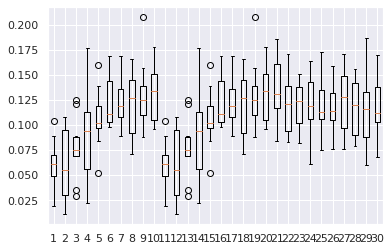

In [99]:
plt.boxplot(knn_results)
plt.show()

Text(0, 0.5, 'Cohen Kappa Score')

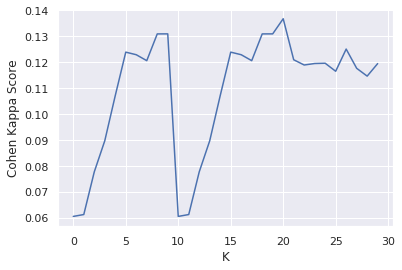

In [100]:
plt.plot(np.mean(knn_results, axis=1), '-')
plt.xlabel('K')
plt.ylabel('Cohen Kappa Score')

## plotting

In [41]:
import seaborn as sns
sns.set()

In [63]:
names[0] = 'Logistic Regression'

In [84]:
results = results[:-1]
names = names[:-1]

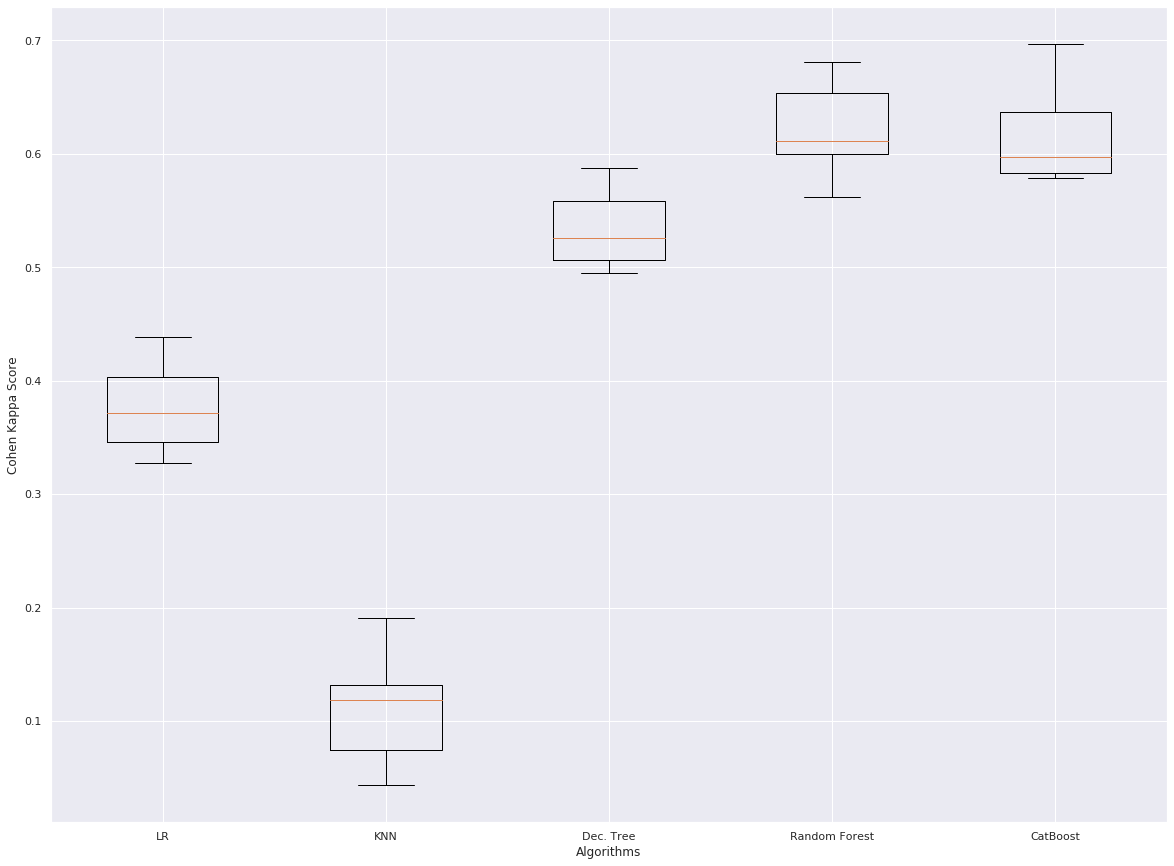

In [103]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.xlabel('Algorithms')
plt.ylabel('Cohen Kappa Score')
ax.set_xticklabels(names)
# plt.show()
plt.savefig('../figures/algorithm_comparison.png')

## Performance on test data

In [ ]:
test_scores = list()
for model in models:
    model_obj = model[1]
    model_obj.fit(X_train, y_train)
    y_pred = model_obj.predict(X_test)
    test_scores.append(cohen_kappa_score(y_pred, y_test))
    

[Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'Dec. Tree'),
 Text(0, 0, 'Random Forest'),
 Text(0, 0, 'CatBoost')]

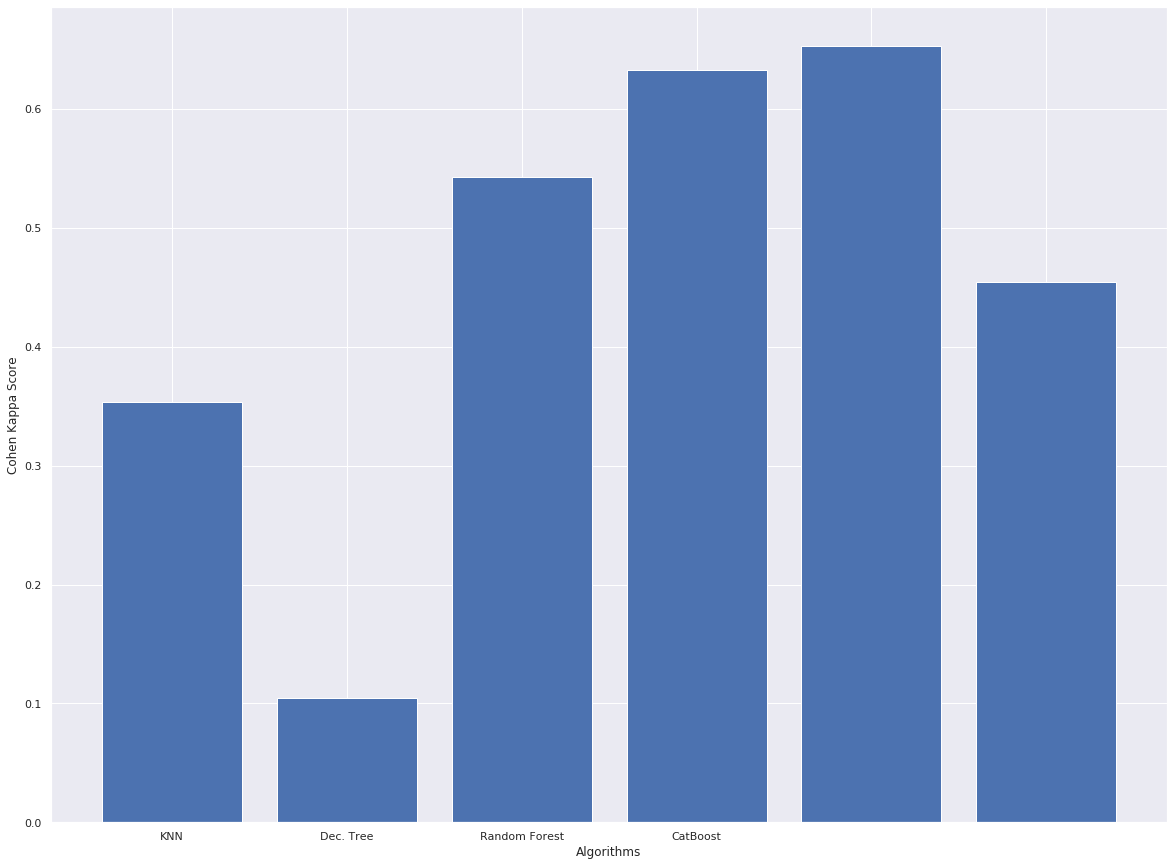

In [109]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
plt.bar(np.arange(len(test_scores)), test_scores)
plt.xlabel('Algorithms')
plt.ylabel('Cohen Kappa Score')
ax.set_xticklabels(names)

In [106]:
print('test')

test


In [107]:
test_scores

[0.3539745369321575,
 0.10432938817996085,
 0.5432070078377131,
 0.6324904463777543,
 0.6532948766365783,
 0.4545013786404043]